<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/old/AssignmentsPart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="#FFD700"> Designing a chemical dispenser

In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
     import dlroms.fespaces as fe

In [ ]:
import numpy as np
import importlib
import dispenser
importlib.reload(dispenser)

from dispenser import FOMsolver, FOMsolverhom, Vh, Vb, compute_basis_functions

## 🔍 Problem Overview

This project focuses on the simulation of a **chemical dispenser** system, where the goal is to precisely control the flow and mixing of chemicals using fluid dynamics. The system must ensure:
- Accurate dosing
- Minimal chemical waste
- Safe handling of hazardous substances

### 🧪 Physical Setup

The prototype dispenser consists of a 2D tank with two inflow gates and two outflow gates:

- **Top inflow gate** \( $\Gamma_{in,1}$ \): where the chemical is introduced.
- **Bottom-left inflow gate** \( $\Gamma_{in,2}$ \): used to control additional fluid injection.
- **Outflow gates** \( $\Gamma_{out,1}$ \) and \( $\Gamma_{out,2}$ \): where the chemical exits.

The flow configuration is controlled by three parameters:
- $c_1 $: horizontal velocity at \( $\Gamma_{in,1}$ \)
- $c_2 $, $c_3 $: horizontal and vertical velocities at \( $\Gamma_{in,2}$ \)

---

### 🌊 Governing Equations

#### 1. Stokes Equation (for fluid velocity \( \mathbf{b} \))
To model the fluid motion inside the tank, we solve the stationary incompressible Stokes equations:

$$
\begin{cases}
- \Delta \mathbf{b} - \nabla p = 0 & \text{in } \Omega, \\
\nabla \cdot \mathbf{b} = 0 & \text{in } \Omega, \\
\mathbf{b} = [c_1, 0]^\top & \text{on } \Gamma_{\text{in},1}, \\
\mathbf{b} = [c_2, c_3]^\top & \text{on } \Gamma_{\text{in},2}, \\
\mathbf{b} = 0 & \text{on } \partial \Omega \setminus (\Gamma_{\text{in},1} \cup \Gamma_{\text{in},2})
\end{cases}
$$

Here, \( \mathbf{b}: \Omega \rightarrow \mathbb{R}^2 \) is the velocity field and \( p \) is the pressure.

---

#### 2. Advection-Diffusion Equation (for chemical concentration \( u \))
After computing the velocity field, we simulate the chemical concentration \( u(x,t) \) using a time-dependent advection-diffusion equation:

$$
\begin{cases}
\frac{\partial u}{\partial t} - \Delta u + \mathbf{b} \cdot \nabla u = 0 & \text{in } \Omega \times (0,T), \\
\nabla u \cdot \mathbf{n} = 0 & \text{on } (\partial \Omega \setminus \Gamma_{\text{in},1}) \times (0,T), \\
u = 1 & \text{on } \Gamma_{\text{in},1} \times (0,T), \\
u(x, 0) = \chi_{\Gamma_{\text{in},1}}(x) & \text{in } \Omega.
\end{cases}
$$

This models how the chemical introduced at the top gate gets transported and diffused through the tank under the influence of the flow field \( \mathbf{b} \).

---

### 🎯 Objective

Before proceeding with physical testing, the goal is to **simulate the system numerically** to understand how the design parameters \($ c_1, c_2, c_3$\) influence the chemical distribution. This involves solving the coupled Stokes and advection-diffusion equations efficiently, and eventually constructing a reduced-order model (ROM) for rapid simulations.



##<font color="#FFD700"> **Convection-diffusion equation**: designing a chemical dispenser

## 🧮 Task 1: Reformulating the Advection-Diffusion Problem

In this task, we reformulate the original advection-diffusion equation by introducing a **homogenized variable**:

$$
u_{\text{hom}} := u - 1.
$$

This transformation simplifies the boundary conditions, converting the Dirichlet condition on \($\Gamma_{in,1}$\) into a homogeneous condition.

The solution $u$ can then be expressed as:

$$
u = u_{\text{hom}} + 1,
$$

where $u_{hom}$ satisfies a modified advection-diffusion equation. The velocity field $b$ is defined as a linear combination of three precomputed basis functions:

$$
b = c_1 b_1 + c_2 b_2 + c_3 b_3,
$$

where each basis function $b_i$ corresponds to unit parameter value $c_i = 1 $ with other coefficients $c_j = 0$ for $j \neq i$.

### Key Advantages of this Reformulation:
1. **Decouples** the fluid dynamics (Stokes problem) from the chemical transport model.
2. Allows us to focus **exclusively** on solving the homogenized advection-diffusion system.

In [ ]:
# Compute basis functions
b1, b2, b3 = compute_basis_functions()
dispenser.b1 = b1  # Make b1, b2, b3 available in dispenser.py
dispenser.b2 = b2
dispenser.b3 = b3

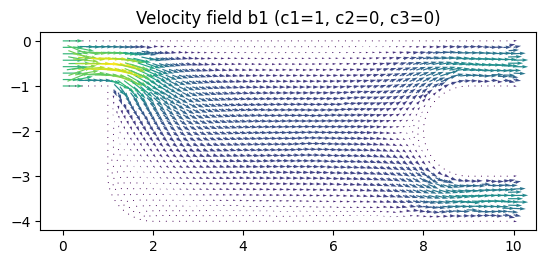

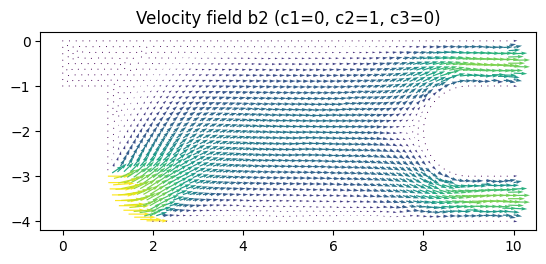

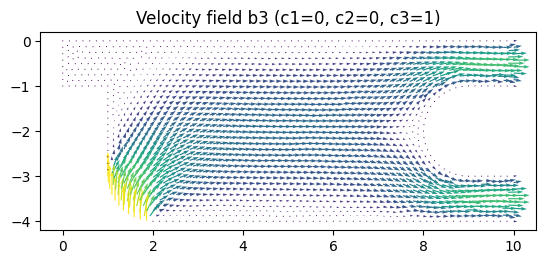

In [ ]:
import matplotlib.pyplot as plt
from fenics import plot

# Convert to FEniCS Function for plotting
bf1 = fe.asfunction(b1, Vb)
bf2 = fe.asfunction(b2, Vb)
bf3 = fe.asfunction(b3, Vb)

# Plot b1
plt.figure()
plot(bf1, title="Velocity field b1 (c1=1, c2=0, c3=0)")
plt.show()

# Plot b2
plt.figure()
plot(bf2, title="Velocity field b2 (c1=0, c2=1, c3=0)")
plt.show()

# Plot b3
plt.figure()
plot(bf3, title="Velocity field b3 (c1=0, c2=0, c3=1)")
plt.show()


In [ ]:
c0= np.array([40, 20, 30])
u = FOMsolver(*c0)
u.shape


(701, 1940)

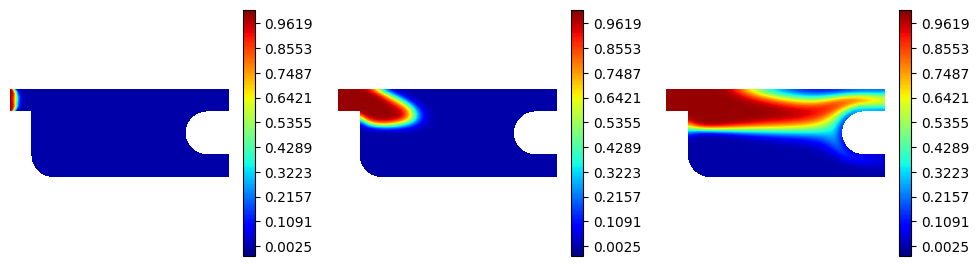

In [ ]:
fe.multiplot(u[[10, 200, 700]], (1, 3), Vh, vmin=u.min(), vmax=u.max(),colorbar = True)

In [ ]:
uhom, *_ =FOMsolverhom(*c0)
uhom.shape

(701, 1940)

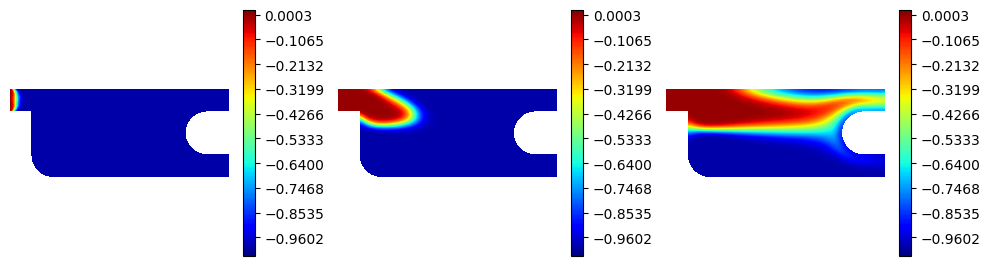

In [ ]:
fe.multiplot(uhom[[10, 200, 700]], (1, 3), Vh, vmin=uhom.min(), vmax=uhom.max(), colorbar = True)

In [ ]:
# Verify that u = uₕₒₘ + 1
error = np.max(np.abs(u - (uhom + 1)))
print(f"Maximum error between u and uₕₒₘ + 1: {error}")

Maximum error between u and uₕₒₘ + 1: 0.00716084910853515


The error is computed using the maximum absolute difference between the discrete solution and the homogenized solution:

$$
E = \max_i \left| u_i - (u_{\text{hom},i} + 1) \right|
$$

where:
- $u_i$ is the discrete numerical solution
- $u_{\text{hom},i}$ is the homogenized solution

In [ ]:
fe.animate(u[::10], Vh)

In [ ]:
fe.animate(u_hom[::10], Vh)

In [ ]:
from dispenser import bottomOutflow

print(bottomOutflow(u))
print(bottomOutflow(uhom))

0.022940463063376885
-0.9769096209275409


## 🧮 Task 2: Data Generation and POD Analysis

In this task, we will generate the dataset required to construct a **Reduced Order Model (ROM)**. The data consists of simulation results for different fluid velocity configurations defined by the parameter vector:

$$
\boldsymbol{\mu} = [c_1, c_2, c_3]
$$

where \( $c_1, c_2, c_3$ ∈ [0, 50] \). We will sample \( N = 20 \) random combinations of these parameters and run full-order simulations for each case.

Once the simulations are complete, we will:

- Split the data in half:
  - 10 simulations for **training**, and  
  - 10 simulations for **testing** the ROM.
- Assemble the **snapshot matrix** using the training data.
- Perform **Singular Value Decomposition (SVD)** on the snapshot matrix.
- Analyze the **decay of the singular values** to determine the appropriate number of basis functions to retain in the POD-Galerkin ROM.

The goal is to identify how many basis functions are necessary to capture the dominant dynamics of the system while minimizing the model's complexity.


In [ ]:
np.random.seed(0)

nsim = 20
cList = []
uhomList = []

for j in range(nsim):
  cj = 50 * np.random.rand(3)
  uhomj, u0j = FOMsolverhom(*cj)

  cList.append(cj)
  uhomList.append(uhomj)


In [ ]:
c = np.stack(cList)
uhom = np.stack(uhomList)
c.shape

(100, 3)

In [ ]:
uhom.shape # snapshots matrix: Nh x Nsamples

(100, 701, 1940)

In [ ]:
ntrain = nsim // 2
Utrain = uhom[:ntrain].reshape(-1, Vh.dim()).T
Utrain.shape

(1940, 35050)

In [ ]:
from scipy.linalg import svd
X, s, Yt = svd(Utrain, full_matrices = False)


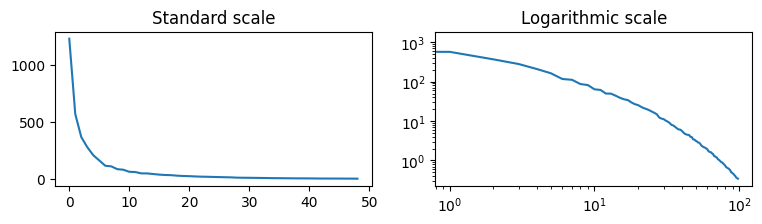

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.plot(s[1:50])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.loglog(s[1:100])
plt.title("Logarithmic scale")
plt.show()

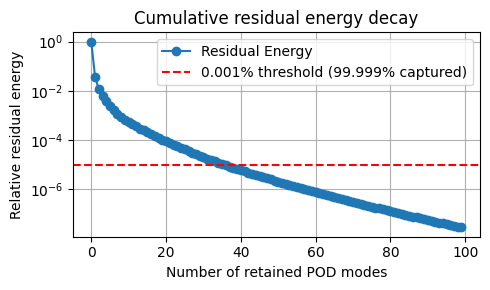

Selected number of POD modes (n): 36
Corresponding residual energy: 9.26e-06


In [ ]:
# Energy decay
total_energy = np.sum(s**2)
residual_energy = np.cumsum(s[::-1]**2)[::-1] / total_energy  # residual energy = 1 - explained

# Plot
plt.figure(figsize=(5, 3))
plt.plot(residual_energy[:100], 'o-', label='Residual Energy')
plt.xlabel("Number of retained POD modes")
plt.ylabel("Relative residual energy")
plt.title("Cumulative residual energy decay")
plt.grid(True)
plt.yscale("log")
plt.axhline(1e-5, color='red', linestyle='--', label='0.001% threshold (99.999% captured)')
plt.legend()
plt.tight_layout()
plt.show()

# Choose dimension for ROM (99.9% energy captured)
tolerance = 1e-5  # 0.1% residual
n_opt = np.argmax(residual_energy <= tolerance)

print(f"Selected number of POD modes (n): {n_opt}")
print(f"Corresponding residual energy: {residual_energy[n_opt]:.2e}")


<font color='Orange'> Residual energy tells you how much information (energy) is not captured by your reduced basis (POD modes). It is a measure of the loss in the reduced approximation.

In [ ]:
n =36
V = X[:, :n]

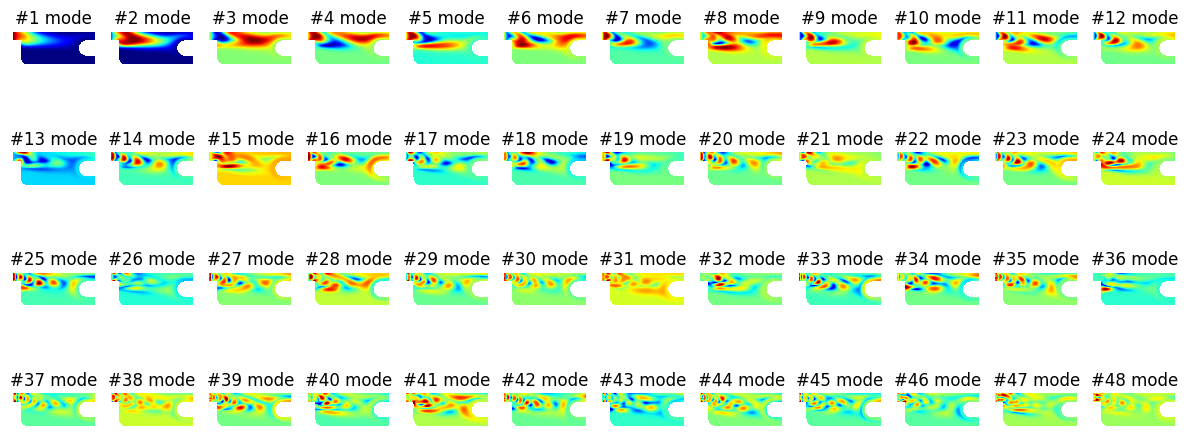

In [ ]:
plt.figure(figsize = (15, 6))
for k in range(n):
  plt.subplot(4, n//4, k+1)
  fe.plot(V[:, k], Vh)
  plt.title("#%d mode" % (k+1))
plt.show()

In [ ]:
from dlroms import num2p
Utest = uhom[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest) #offline projection error
#It measures how well a fixed reduced basis approximates your FOM snapshots.

errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

ntest = uhom.shape[0] - ntrain
errors = errors.reshape(ntest, uhom.shape[1])
avg_rel_error = errors.mean()

print(f"Average relative error over the test set: {num2p(avg_rel_error)}")

print("Average projection error: %s." % num2p(errors.max(axis = 1).mean()))

Average relative error over the test set: 0.24%
Average projection error: 0.62%.


This is a low-rank approximation of the solution, where only the dominant patterns of the solution are kept, thanks to the POD procedure.
### Formula:

$$E_{\text{proj}}=\frac{1}{N_{\text{test}}}\sum_{j=1}^{N_{\text{test}}}\left(\max_{k=0,\dots,N_t}\;\frac{\|\mathbf{u}_{j,k}^{\text{test}}-\mathbf{V}\mathbf{V}^\top\mathbf{u}_{j,k}^{\text{test}}\|}{\|\mathbf{u}_{j,k}^{\text{test}}\|}\right)$$
</br>where $\mathbf{u}_{i}^{\text{test}}$ are the simulations in the test set.


## 🧮 Task 3: POD-Galerkin ROM Implementation

In this task, we implement a reduced basis solver using the POD-Galerkin method. All key operators are pre-computed to make the online stage efficient.

We compare the efficiency (runtime) and accuracy (average relative error over 10 test simulations) of the RB solver against the full-order model using the same time-step $\Delta t = 5 \cdot 10^{-4}$.

Finally, we analyze how:
1. The error evolves over time
2. The error is distributed across test cases

In [ ]:
from dispenser import assemble_FOM_matrices

M, S, B1, B2, B3 = assemble_FOM_matrices()

Mrb  = V.T @ M  @ V
Srb  = V.T @ S  @ V
B1rb = V.T @ B1 @ V
B2rb = V.T @ B2 @ V
B3rb = V.T @ B3 @ V


In [ ]:
def RBstep(cn, dt, mu):
    c1, c2, c3 = mu
    Arb = Mrb + dt * Srb + dt * (c1 * B1rb + c2 * B2rb + c3 * B3rb)
    Frb = Mrb @ cn
    return np.linalg.solve(Arb, Frb)

In [ ]:
u0 = u0j
u0.shape

(1940,)

In [ ]:
def RBsolver(mu, dt=5e-4, steps=700):
    c0 = V.T @ u0  # Project initial condition to reduced space
    c = [c0]

    for _ in range(steps):
        c.append(RBstep(c[-1], dt, mu))

    c = np.stack(c)
    u = c @ V.T # lifting to FOM
    u[0] = u0  # Set initial condition back in full space
    return u

In [ ]:
from time import perf_counter
mu0 = np.array([40, 20, 30])
t0 = perf_counter()
uFOM0, _ = FOMsolverhom(*mu0)
t1 = perf_counter()
dtFOM = t1 - t0
print("FOM evaluation time: %.2f milliseconds." % (1000*dtFOM))

t0 = perf_counter()
uRB0 = RBsolver(mu0)
t1 = perf_counter()
dtROM = t1 - t0
print("ROM evaluation time: %.2f milliseconds." % (1000*dtROM))
print("\n>> Boost: x%d." % (dtFOM//dtROM))

FOM evaluation time: 14986.07 milliseconds.
ROM evaluation time: 45.09 milliseconds.

>> Boost: x332.


Average amount of chemical that has exited the domain (FOM): -0.97691
Average amount of chemical that has exited the domain (RB):  -0.97632


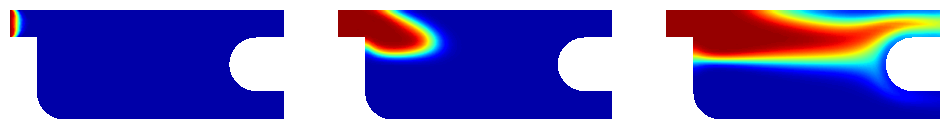

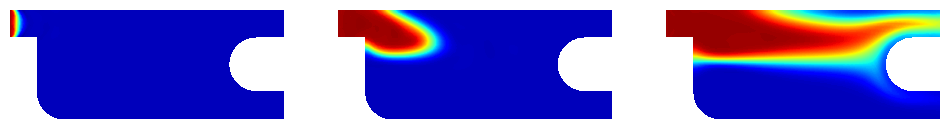

In [ ]:
#fe.multiplot(uRB[[10, 200, 700]], (1, 3),Vh)
fe.multiplot(uFOM0[[10, 200, 700]], (1, 3), Vh, vmin=uFOM0.min(), vmax=uFOM0.max())
plt.title("FOM solution")
fe.multiplot(uRB0[[10, 200, 700]],  (1, 3),Vh, vmin=uRB0.min(), vmax=uRB0.max())
plt.title("RB solution")

j_fom = bottomOutflow(uFOM0)
print(f"Average amount of chemical that has exited the domain (FOM): {j_fom:.5f}")

j_rb = bottomOutflow(uRB0)
print(f"Average amount of chemical that has exited the domain (RB):  {j_rb:.5f}")


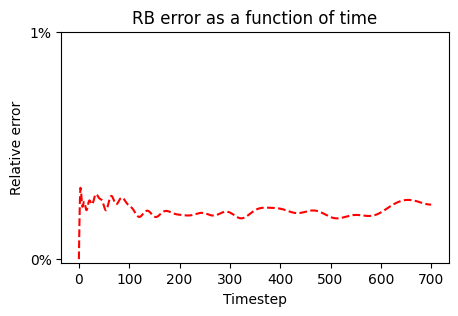

In [ ]:
errors = np.linalg.norm(uFOM0 - uRB0, axis=1) / np.linalg.norm(uFOM0, axis=1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.01], ["0%", "1%"])
plt.show()


### Formula:
For one test parameter $\mu_0$, and for each time step $t_k$,

$$
\text{Error}(t_k) = \frac{\| u_{\text{FOM}}(t_k) - u_{\text{RB}}(t_k) \|}{\| u_{\text{FOM}}(t_k) \|}
$$

### What it does:
Computes and plots the relative error over time for one simulation.

In [ ]:
mu_test = c[ntrain:] # Use 10 test samples from your dataset
Utest = uhom[ntrain:]
URBtest = [RBsolver(m) for m in mu_test]

URBtest = np.stack(URBtest)
errors = np.linalg.norm(Utest-URBtest, axis = -1)/np.linalg.norm(Utest, axis = -1)
etest = errors.max(axis = -1).mean()

print("Average uniform relative error: %s." % num2p(etest))


Average uniform relative error: 0.66%.


### Formula:
For each test case \( j = 1, \dots, 10 \), compute the maximum error in time, then average across test cases:

$$
Error_{\text{test}}=\frac{1}{N_{\text{test}}}\sum_{j=1}^{N_{\text{test}}}\left(\max_{k=0,\dots,N_t}\;\frac{\|\mathbf{u}_{j,k}^{\text{test}}-\mathbf{u}_{\boldsymbol{\mu}^{\text{test}}_{j}, k}^{rb}\|}{\|\mathbf{u}_{j,k}^{\text{test}}\|}\right)
$$

### What it does:
Reports the **mean of max time errors per test case**.

✅ **Use**:  
Provides a worst-case estimate per simulation. Useful when you're sensitive to peak errors.

In [ ]:
from time import time
from matplotlib import pyplot as plt

# Store time-resolved errors
timewise_errors_all = []
rel_errors_timewise = []
times_fom = []
times_rb = []
J_errors = []


for j, mu in enumerate(mu_test):
    # FOM
    t0 = time()
    u_fom, _ = FOMsolverhom(*mu, steps=700, dt=5e-4)
    times_fom.append(time() - t0)
    J_fom = bottomOutflow(u_fom)

    # RB
    u0 = u0j
    t0 = time()
    u_rb = RBsolver(mu, dt=5e-4, steps=700)
    times_rb.append(time() - t0)
    J_rb = bottomOutflow(u_rb)

    # Compute relative error per timestep
    rel_error_t = np.linalg.norm(u_fom - u_rb, axis=1) / np.linalg.norm(u_fom, axis=1)
    timewise_errors_all.append(rel_error_t)
    rel_errors_timewise.append(np.mean(rel_error_t))  # avg error per simulation

    # Relative error in functional
    err_J = abs(J_fom - J_rb) / abs(J_fom)
    J_errors.append(err_J)

# Convert to array
timewise_errors_all = np.array(timewise_errors_all)

import numpy as np

print(f"\nAverage FOM time: {np.mean(times_fom):.3f} s")
print(f"Average RB time: {np.mean(times_rb):.3f} s")
print(f"Average Speedup factor: {np.mean(times_fom) / np.mean(times_rb):.1f}x")


Average FOM time: 15.585 s
Average RB time: 0.052 s
Average Speedup factor: 300.9x


In [ ]:
rel_errors_timewise = np.array(rel_errors_timewise)
print(f"\nAverage relative error over the test set: {np.mean(rel_errors_timewise):.3%}")
print(f"Max relative error across simulations: {np.max(rel_errors_timewise):.3%}")




Average relative error over the test set: 0.306%
Max relative error across simulations: 1.354%
Standard deviation of relative errors: 0.251%


## Error Metrics Formulae

### 1. Time-resolved Relative Error (per test case)
For each test case $j$ and time step $t_k$:

$$
e_j(t_k) = \frac{\| u_{\text{FOM}}^{(j)}(t_k) - u_{\text{RB}}^{(j)}(t_k) \|}{\| u_{\text{FOM}}^{(j)}(t_k) \|}
$$

### 2. Average Error per Simulation
For each test case $j$, averaged over all time steps:

$$
Error_j = \frac{1}{701} \sum_{k=1}^{701} e_j(t_k)
$$

###3. Overall Average Error over the Test Set

Averaged over all test cases (assuming 10 test cases as implied by the summation limit):

$$
\text{Average Overall Error} = \frac{1}{10} \sum_{j=1}^{10} \text{Error}_j
$$

### 4. Max Relative Error Across Simulations

The maximum of the average simulation errors over all test cases:

$$
\text{Max Relative Error} = \max_{j=1,\ldots,10} \left( \text{Error}_j \right)
$$



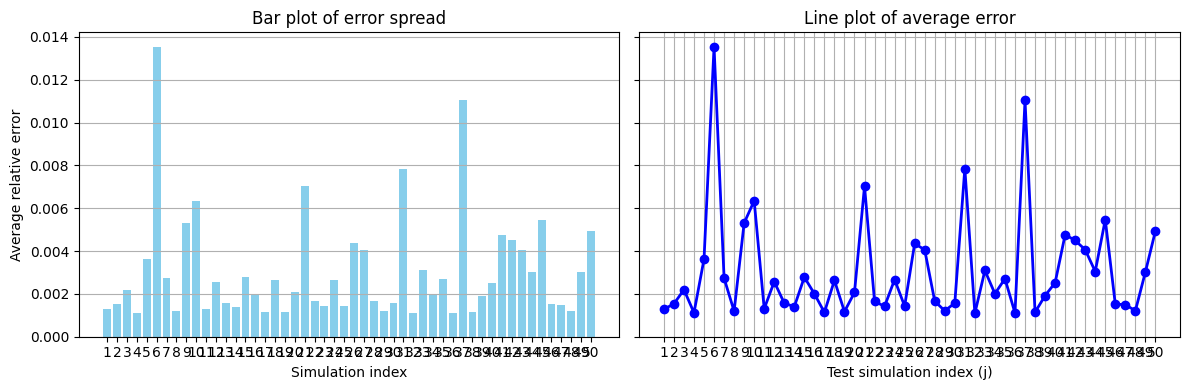

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# x-axis: simulation index (1 to 10)
x = np.arange(1, len(rel_errors_timewise) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Left subplot: Bar chart ---
axs[0].bar(x, rel_errors_timewise, color="skyblue")
axs[0].set_xlabel("Simulation index")
axs[0].set_ylabel("Average relative error")
axs[0].set_title("Bar plot of error spread")
axs[0].set_xticks(x)
axs[0].grid(True, axis='y')

# --- Right subplot: Line plot ---
axs[1].plot(x, rel_errors_timewise, 'o-', color='blue', linewidth=2)
axs[1].set_xlabel("Test simulation index (j)")
axs[1].set_title("Line plot of average error")
axs[1].set_xticks(x)
axs[1].grid(True)
axs[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()



/tmp/ipython-input-72-4065041794.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


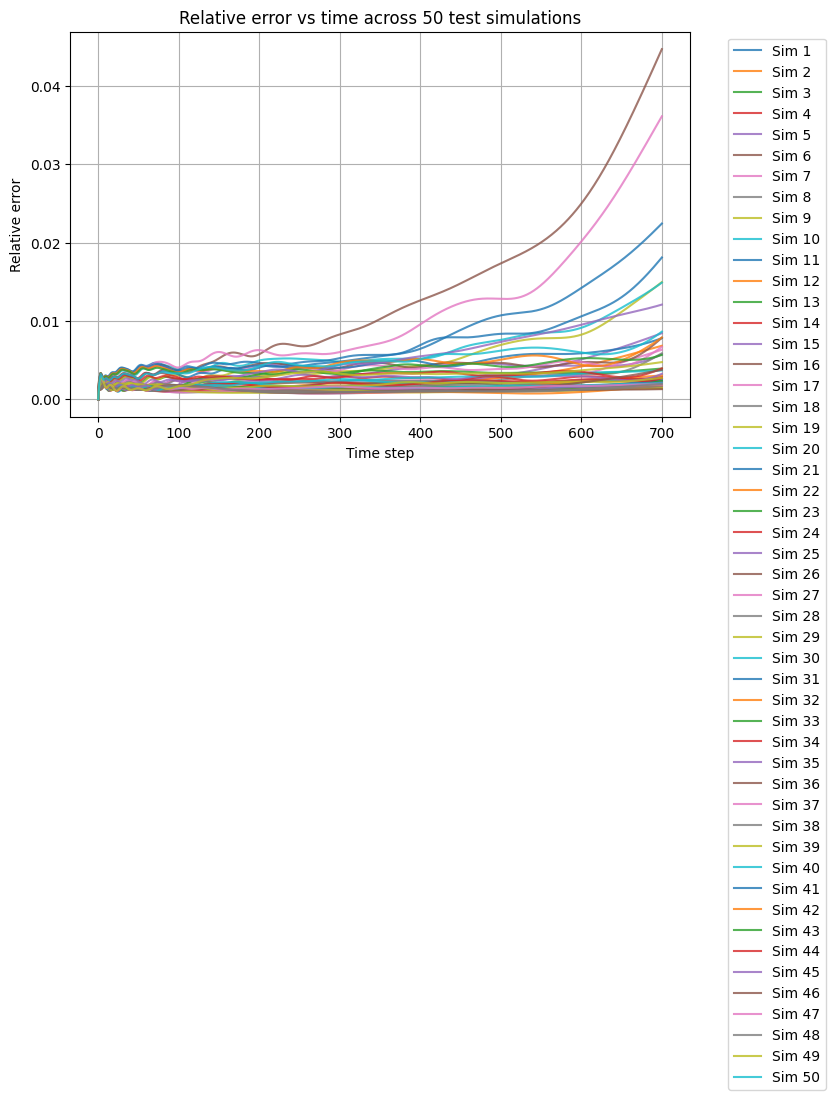

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for j in range(len(mu_test)):  # or simply: range(10)
    plt.plot(timewise_errors_all[j], label=f"Sim {j+1}", alpha=0.8)

plt.xlabel("Time step")
plt.ylabel("Relative error")
plt.title("Relative error vs time across 10 test simulations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧮 Task 4 – Functional Evaluation and Optimization

In this task, we aim to optimize the delivery of a chemical by minimizing the amount that exits through the bottom gate $\Gamma_{\text{out},2}$. The performance of a given velocity field is quantified by the output functional:

$$
J(u) = \frac{1}{T} \int_{0}^{T} \int_{\Gamma_{\text{out},2}} u(s,t) \, ds \, dt
$$

This represents the average concentration flowing out of the bottom gate over time.

To study how the velocity direction affects this outflow, we fix $c_1 = 50$ and define:

$$
\mu(\theta) = [50, \cos(\theta), \sin(\theta)], \quad \theta \in \left[0, \frac{\pi}{2}\right]
$$

Using the reduced-order model (ROM), we compute the corresponding solution $u_\theta$ and evaluate $J(u_\theta)$ for various values of $\theta$. By plotting $\theta \mapsto J(u_\theta)$, we can identify the optimal angle $\theta^*$ that minimizes outflow through the bottom, thereby maximizing chemical delivery to the top gate.

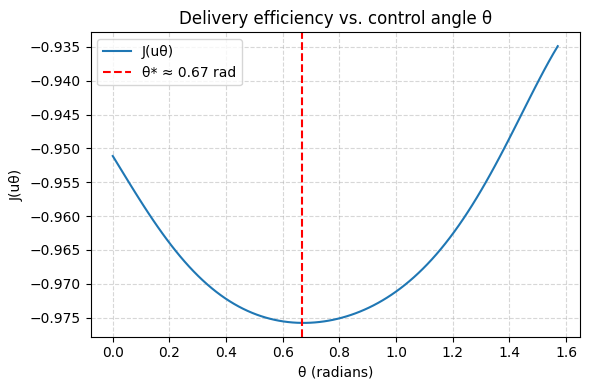

Optimal θ* ≈ 0.6664 radians ≈ 38.18 degrees
Minimum J(uθ) ≈ -0.975795


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dispenser import bottomOutflow

# Define parameters
c1 = 50
theta_vals = np.linspace(0, np.pi / 2, 100)
J_vals = []

# Loop over θ values
for theta in theta_vals:
    c2 = 50*np.cos(theta)
    c3 = 50*np.sin(theta)
    mu = [c1, c2, c3]

    u_theta = RBsolver(mu, dt=5e-4, steps=700)  # same dt and steps as FOM
    J_val = bottomOutflow(u_theta)
    J_vals.append(J_val)

# Find the optimal theta
theta_star_index = np.argmin(J_vals)
theta_star = theta_vals[theta_star_index]
J_min = J_vals[theta_star_index]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(theta_vals, J_vals, label='J(uθ)')
plt.axvline(theta_star, color='r', linestyle='--', label=f'θ* ≈ {theta_star:.2f} rad')
plt.xlabel("θ (radians)")
plt.ylabel("J(uθ)")
plt.title("Delivery efficiency vs. control angle θ")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Optimal θ* ≈ {theta_star:.4f} radians ≈ {np.degrees(theta_star):.2f} degrees")
print(f"Minimum J(uθ) ≈ {J_min:.6f}")